# Loading new data

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from modules import *
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import glob
import tqdm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import cm
import itertools

In [2]:
# file = "H:\Github\Antarctica-M.2\data\land ice\GRCTellus.JPL.200204_202008.GLO.RL06M.MSCNv02CRI.nc"
# ds = xr.open_dataset(file)
# ds

In [3]:
# data  = ds.lwe_thickness

In [4]:
# trend = data.polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1).sel(lat=slice(-90,-50))

# ax = plt.axes(projection=ccrs.SouthPolarStereo())
# contour = ax.contourf(trend.lon, trend.lat, trend.values, transform=ccrs.PlateCarree(), cmap = 'RdBu')
# plt.colorbar(contour)
# ax.coastlines()
# plt.show()

# Temperature

In [5]:
files = glob.glob('processed_data/*')
variables  = ['t2m.nc', 'skt.nc', 'sst.nc']
files = [f for f in files if '_' not in f.split('\\')[1] and  f.split('\\')[1] in variables]
ds = xr.open_mfdataset(files, parallel=True, compat='override')

ds = ds.compute()

ModuleNotFoundError: No module named 'dask'

In [ ]:
ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
#       .pipe(w5.normalise_indepenant, dependant='sic')
     )
ds

In [7]:
area = xr.open_dataset('data/area_files/processed_nsidc.nc').area

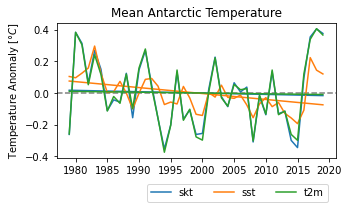

In [8]:
fig = plt.figure(figsize=(5,2.5))
plt.axhline(0, color = 'black',alpha = 0.5, linestyle='--')
gradient = xr.Dataset()
for t in ds:
    data = (ds[t]*area).mean(dim=('x','y'))/area.mean(dim=('x','y'))
    m, b = data.polyfit(deg=1, dim='time').polyfit_coefficients 
    yfit = m*data.time.astype(float) +b
    plot = plt.plot(data.time, data,label = t)
    plt.plot(data.time, yfit, color = plot[0].get_color())
plt.legend(bbox_to_anchor=(0.99, -0.15), ncol = 3, loc = 'upper right')
plt.title('Mean Antarctic Temperature')
plt.ylabel('Temperature Anomaly [$\degree C$]')
plt.savefig('images/week6/TemperatureTimeseries.png', bbox_inches='tight')
plt.show()

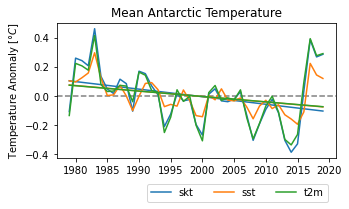

In [9]:
fig = plt.figure(figsize=(5,2.5))
plt.axhline(0, color = 'black',alpha = 0.5, linestyle='--')
gradient = xr.Dataset()
dscopy = ds.stack(z=('x','y')).dropna(dim='z').unstack().copy()
for t in ds:
    data = (dscopy[t]*area).mean(dim=('x','y'))/area.mean(dim=('x','y'))
    m, b = data.polyfit(deg=1, dim='time').polyfit_coefficients 
    yfit = m*data.time.astype(float) +b
    plot = plt.plot(data.time, data,label = t)
    plt.plot(data.time, yfit, color = plot[0].get_color())
plt.legend(bbox_to_anchor=(0.99, -0.15), ncol = 3, loc = 'upper right')
plt.title('Mean Antarctic Temperature')
plt.ylabel('Temperature Anomaly [$\degree C$]')
plt.savefig('images/week6/TemperatureTimeseries_filtered.pdf', bbox_inches='tight')
plt.show()

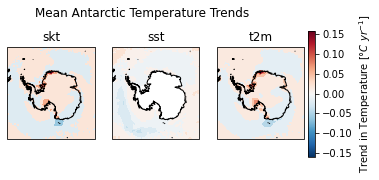

In [10]:
fig = plt.figure(figsize=(5,2.5))

gradient = xr.Dataset()
for t in ds:
    gradient[t] = ds[t].polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1)* 1e9*60*60*24*365

max_ = max([gradient[indexname].max() for indexname in gradient])
min_ = min([gradient[indexname].min() for indexname in gradient])

max_ = max(max_,-min_)
min_ = -max_

if max_>min_ and max_>0 and min_<0:
    divnorm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
else:
    sys.exit(f'min = {min_.values}, max = {max_.values}, {variables}')
i=0
for t in ds:
    ax = fig.add_subplot(1,3,i+1, projection = ccrs.SouthPolarStereo())
    data = gradient[t]
    contour = ax.contourf(data.x, data.y, data, cmap='RdBu_r', norm=divnorm)
    ax.set_title(t)
    ax.coastlines()
    i +=1
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=divnorm, cmap='RdBu_r'), cax=cbar_ax, shrink=0.88)
cbar.set_label('Trend in Temperature [$\degree C\ yr^{-1}$]')
plt.suptitle('Mean Antarctic Temperature Trends')
plt.savefig('images/week6/Temperature_Trends.pdf', bbox_inches='tight')
plt.show()

In [14]:
v = [v for v in ds]

correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm.tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1]
    vec2 = ds[v2]
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values
    
def fmt(val):
    sig_level=0.9
    if val > sig_level or val < -sig_level:
        return f'\\textbf{{{val:.3f}}}'
    else:
        return f'{{{val:.3f}}}'

pd.set_option('display.float_format', fmt)
correlation_matrix.index = [f'\\textbf{{{ind.upper()}}}' for ind in correlation_matrix.index]
correlation_matrix.columns = [f'\\textbf{{{ind.upper()}}}' for ind in correlation_matrix.columns]
correlation_matrix.to_latex('images/week6/temperature_correlations.tex', escape=False)
correlation_matrix

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.75it/s]


,\textbf{V10},\textbf{U10},\textbf{SP},\textbf{SSR},\textbf{T2M}
\textbf{V10},\textbf{1.000},{-0.105},{0.014},{0.031},{-0.327}
\textbf{U10},{-0.105},\textbf{1.000},{-0.122},{0.077},{-0.103}
\textbf{SP},{0.014},{-0.122},\textbf{1.000},{-0.110},{0.217}
\textbf{SSR},{0.031},{0.077},{-0.110},\textbf{1.000},{0.065}
\textbf{T2M},{-0.327},{-0.103},{0.217},{0.065},\textbf{1.000}


# Regressing Temperature onto Sea Ice

C:\Users\hjzoo\anaconda3\envs\amongus\lib\site-packages\xarray\core\indexing.py:1294: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return array[key]


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 dask.array<where, shape=(41, 332, 316), dty...
    t2m      (time, y, x) float64 dask.array<where, shape=(41, 332, 316), dty...
    skt      (time, y, x) float64 dask.array<where, shape=(41, 332, 316), dty...
    sic      (time, y, x) float64 dask.array<concatenate, shape=(41, 332, 316...


C:\Users\hjzoo\anaconda3\envs\amongus\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\hjzoo\anaconda3\envs\amongus\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Finding coefficients for ['sst', 't2m', 'skt'] against sic


100%|████████████████████████████████████████████████████████████████████████| 104912/104912 [00:29<00:00, 3534.28it/s]


Predicting SIC


TypeError: lstsq() got an unexpected keyword argument 'rcond'

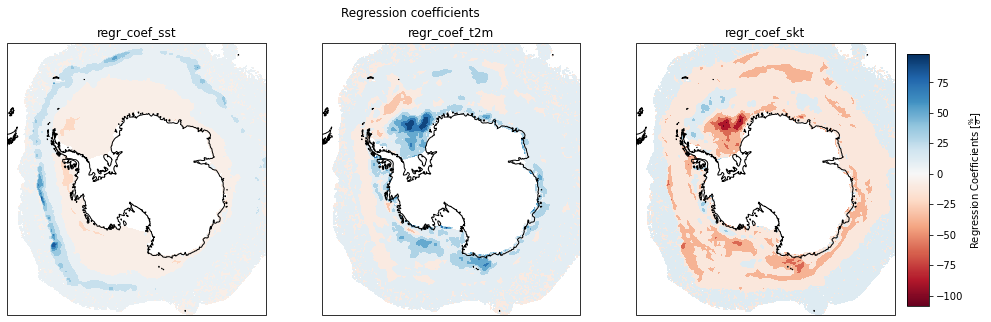

In [9]:
for ind in [
#             ['sst'],['skt'],['t2m'],
#             ['sst','t2m'], ['t2m','skt'], ['skt','sst'],
            ['sst', 't2m','skt']]:
    files = glob.glob('processed_data/*')
    files = [f for f in files if '_' not in f.split('\\')[1]]
    ds = xr.open_mfdataset(files, parallel=True, compat='override')

    dependant = 'sic'
    independant = ind
    ds = ds[independant + [dependant]]

    ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
    ds = (ds
          .pipe(w5.find_anomalies)
          .pipe(w5.yearly_average)
          .pipe(w5.normalise_indepenant, dependant='sic')
         ).compute()

    print(ds)

    regression_results = w5.multiple_fast_regression(ds, dependant, independant)
    w5.plotting(regression_results, dependant, independant, folder='week6')
    w5.more_plotting(regression_results, dependant, independant, folder='week6')

# Statistics of fitting

In [19]:
independant_options = [['sst'],['skt'],['t2m'],
                       ['sst','t2m'], ['t2m','skt'], ['skt','sst'],
                       ['sst', 't2m','skt']]

cols = ['Spatial correlation', 'Temporal correlation', 'Predicted trend', 'Actual trend',
       ]
Statistics = pd.DataFrame(index=[' '.join(ind) for ind in independant_options], columns = cols)
for ind in independant_options:
    files = glob.glob('processed_data/*')
    files = [f for f in files if '_' not in f.split('\\')[1]]
    ds = xr.open_mfdataset(files, parallel=True, compat='override')

    dependant = 'sic'
    independant = ind
    ds = ds[independant + [dependant]]

    ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
    ds = (ds
          .pipe(w5.find_anomalies)
          .pipe(w5.yearly_average)
          .pipe(w5.normalise_indepenant, dependant='sic')
         ).compute()

    print(ds)

    regression_results = w5.multiple_fast_regression(ds, dependant, independant)
#     w5.plotting(regression_results, dependant, independant, folder='week6')
#     w5.more_plotting(regression_results, dependant, independant, folder='week6')
    stats = w4._get_stats(regression_results, 'sic' ,independant)
    stats.name = 'Quality of Regression'
    stats.index = [col.replace('_', ' ').capitalize() for col in stats.index]
    Statistics.loc[' '.join(ind),stats.index] = stats.values
    print(Statistics)
Statistics

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13569.33it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                         NaN                  NaN             NaN   
t2m                         NaN                  NaN             NaN   
sst t2m                     NaN                  NaN             NaN   
t2m skt                     NaN                  NaN             NaN   
skt sst                     NaN                  NaN             NaN   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt                  NaN  
t2m                  NaN  
sst t2m              NaN  
t2m skt              NaN  
skt sst              NaN  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['skt'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13218.75it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                         NaN                  NaN             NaN   
sst t2m                     NaN                  NaN             NaN   
t2m skt                     NaN                  NaN             NaN   
skt sst                     NaN                  NaN             NaN   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m                  NaN  
sst t2m              NaN  
t2m skt              NaN  
skt sst              NaN  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['t2m'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13313.48it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                     {0.690}              {0.873}         {0.029}   
sst t2m                     NaN                  NaN             NaN   
t2m skt                     NaN                  NaN             NaN   
skt sst                     NaN                  NaN             NaN   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m              {0.030}  
sst t2m              NaN  
t2m skt              NaN  
skt sst              NaN  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst', 't2m'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13192.58it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                     {0.690}              {0.873}         {0.029}   
sst t2m                 {0.889}       \textbf{0.912}         {0.026}   
t2m skt                     NaN                  NaN             NaN   
skt sst                     NaN                  NaN             NaN   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m              {0.030}  
sst t2m          {0.030}  
t2m skt              NaN  
skt sst              NaN  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['t2m', 'skt'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 12886.74it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                     {0.690}              {0.873}         {0.029}   
sst t2m                 {0.889}       \textbf{0.912}         {0.026}   
t2m skt                 {0.853}              {0.871}         {0.036}   
skt sst                     NaN                  NaN             NaN   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m              {0.030}  
sst t2m          {0.030}  
t2m skt          {0.030}  
skt sst              NaN  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['skt', 'sst'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13200.73it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                     {0.690}              {0.873}         {0.029}   
sst t2m                 {0.889}       \textbf{0.912}         {0.026}   
t2m skt                 {0.853}              {0.871}         {0.036}   
skt sst          \textbf{0.913}       \textbf{0.905}         {0.026}   
sst t2m skt                 NaN                  NaN             NaN   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m              {0.030}  
sst t2m          {0.030}  
t2m skt          {0.030}  
skt sst          {0.030}  
sst t2m skt          NaN  


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst', 't2m', 'skt'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 12259.63it/s]


Predicting SIC
            Spatial correlation Temporal correlation Predicted trend  \
sst                     {0.751}              {0.771}         {0.031}   
skt                     {0.748}              {0.868}         {0.035}   
t2m                     {0.690}              {0.873}         {0.029}   
sst t2m                 {0.889}       \textbf{0.912}         {0.026}   
t2m skt                 {0.853}              {0.871}         {0.036}   
skt sst          \textbf{0.913}       \textbf{0.905}         {0.026}   
sst t2m skt      \textbf{0.937}       \textbf{0.906}         {0.028}   

            Actual trend  
sst              {0.030}  
skt              {0.030}  
t2m              {0.030}  
sst t2m          {0.030}  
t2m skt          {0.030}  
skt sst          {0.030}  
sst t2m skt      {0.030}  


,Spatial correlation,Temporal correlation,Predicted trend,Actual trend
sst,{0.751},{0.771},{0.031},{0.030}
skt,{0.748},{0.868},{0.035},{0.030}
t2m,{0.690},{0.873},{0.029},{0.030}
sst t2m,{0.889},\textbf{0.912},{0.026},{0.030}
t2m skt,{0.853},{0.871},{0.036},{0.030}
skt sst,\textbf{0.913},\textbf{0.905},{0.026},{0.030}
sst t2m skt,\textbf{0.937},\textbf{0.906},{0.028},{0.030}


In [20]:
Statistics.to_latex('images\week6\statistics.tex',  escape=False, column_format='l'*(len(results.index)+1))

# Adding in other variables

In [16]:
independant_options = [
                       ['v10'],['u10'],['sp'],['ssr'],
                       ['v10','u10','sp','ssr'],
                       ['sst', 't2m','skt','v10','u10','sp','ssr']
                      ]

cols = ['Spatial correlation', 'Temporal correlation', 'Predicted trend', 'Actual trend',
       ]
Statistics = pd.DataFrame(index=[' '.join(ind) for ind in independant_options], columns = cols)
for ind in independant_options:
    files = glob.glob('processed_data/*')
    files = [f for f in files if '_' not in f.split('\\')[1]]
    ds = xr.open_mfdataset(files, parallel=True, compat='override')

    dependant = 'sic'
    independant = ind
    ds = ds[independant + [dependant]]

    ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
    ds = (ds
          .pipe(w5.find_anomalies)
          .pipe(w5.yearly_average)
          .pipe(w5.normalise_indepenant, dependant='sic')
         ).compute()

    print(ds)

    regression_results = w5.multiple_fast_regression(ds, dependant, independant)
#     w5.plotting(regression_results, dependant, independant, folder='week6')
#     w5.more_plotting(regression_results, dependant, independant, folder='week6')
    stats = w4._get_stats(regression_results, 'sic' ,independant)
    stats.name = 'Quality of Regression'
    stats.index = [col.replace('_', ' ').capitalize() for col in stats.index]
    Statistics.loc[' '.join(ind),stats.index] = stats.values
#     print(Statistics)

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['v10'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13137.50it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['u10'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 13077.37it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sp'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13208.89it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['ssr'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13250.77it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['v10', 'u10', 'sp', 'ssr'] against sic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:09<00:00, 10966.53it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst', 't2m', 'skt', 'v10', 'u10', 'sp', 'ssr'] 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:10<00:00, 9547.78it/s]


Predicting SIC


In [17]:
Statistics.to_latex('images\week6\statistics_1.tex',  escape=False, column_format='l'*(len(Statistics.columns)+1))
Statistics

,Spatial correlation,Temporal correlation,Predicted trend,Actual trend
v10,{0.336},{0.034},{0.000},{0.030}
u10,{0.326},{0.237},{0.002},{0.030}
sp,{0.171},{0.186},{0.006},{0.030}
ssr,{0.888},{0.587},{0.002},{0.030}
v10 u10 sp ssr,\textbf{0.909},{0.692},{0.009},{0.030}
sst t2m skt v10 u10 sp ssr,\textbf{0.973},\textbf{0.932},{0.025},{0.030}


In [18]:
independant_options = [
                       ['v10'],['u10'],['sp'],['ssr'],
                       ['v10','u10','sp','ssr'],
                      ]

cols = ['Spatial correlation', 'Temporal correlation', 'Predicted trend', 'Actual trend',
       ]
Statistics = pd.DataFrame(index=[' '.join(ind) for ind in independant_options], columns = cols)
for ind in independant_options:
    files = glob.glob('processed_data/*')
    files = [f for f in files if '_' not in f.split('\\')[1]]
    ds = xr.open_mfdataset(files, parallel=True, compat='override')

    dependant = 't2m'
    independant = ind
    ds = ds[independant + [dependant]]

    ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
    ds = (ds
          .pipe(w5.find_anomalies)
          .pipe(w5.yearly_average)
          .pipe(w5.normalise_indepenant, dependant='t2m')
         ).compute()

    print(ds)

    regression_results = w5.multiple_fast_regression(ds, dependant, independant)
#     w5.plotting(regression_results, dependant, independant, folder='week6')
#     w5.more_plotting(regression_results, dependant, independant, folder='week6')
    stats = w4._get_stats(regression_results, 't2m' ,independant)
    stats.name = 'Quality of Regression'
    stats.index = [col.replace('_', ' ').capitalize() for col in stats.index]
    Statistics.loc[' '.join(ind),stats.index] = stats.values
#     print(Statistics)
Statistics.to_latex('images\week6\statistics_2.tex',  escape=False, column_format='l'*(len(Statistics.index)+1))
Statistics

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875
Finding coefficients for ['v10'] against t2m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13161.48it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875
Finding coefficients for ['u10'] against t2m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 12831.22it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875
Finding coefficients for ['sp'] against t2m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13183.88it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875
Finding coefficients for ['ssr'] against t2m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13227.86it/s]


Predicting SIC


C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    v10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.5608 -0.5554 -0.5538
    u10      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 2.552 2.545 2.536 2.521
    sp       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.02608 0.0623 0.099
    ssr      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4578 -0.4181 -0.3338
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875
Finding coefficients for ['v10', 'u10', 'sp', 'ssr'] against t2m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:09<00:00, 11041.01it/s]


Predicting SIC


,Spatial correlation,Temporal correlation,Predicted trend,Actual trend
v10,{0.505},{-0.220},{0.001},{-0.001}
u10,{0.389},{0.347},{0.001},{-0.001}
sp,{0.202},{0.467},{-0.000},{-0.001}
ssr,{0.312},{0.426},{-0.001},{-0.001}
v10 u10 sp ssr,{0.671},{0.592},{0.001},{-0.001}
